# Problema de TItanic


El famoso problema de TItanic consiste en, a partir de datos de los individuos involucrados en el accidente, predecir quienes se salvaron y quienes no.

En este notebook usaremos la libreria Titanic-Fairy para entrenar un modelo que pueda resolver el problema

# Datos

Los datos de la tabla que se usara de entrenamiento se puede resumir en la siguiente tabla 

| Column Name - customers.csv | Description |
|:--|:--|
| Survival | Survival (0 = No; 1 = Yes). Not included in test.csv file | 
| Pclass |  Ticket Class/ A Proxy for socio-economic status(SES) (1 = 1st/Upper ; 2 = 2nd/Middle; 3 = 3rd/Lower) | 
| Name | Name |
| Sex | Sex |
| Age | Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5 |
| Sibsp | Number of Siblings (brother, sister, stepbrother, stepsister) /Spouses (husband, wife (mistresses and fiancés were ignored)) Aboard |
| Parch | Number of Parents (mother, father)/Children (daughter, son, stepdaughter, stepson) Aboard; Some children travelled only with a nanny, therefore parch=0 for them. |
| Ticket | Ticket Number |
| Fare | Passenger Fare |
| Cabin | Cabin |
| Embarked | Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) |

A continuacion veamos como se correlacionan algunas de estas variables

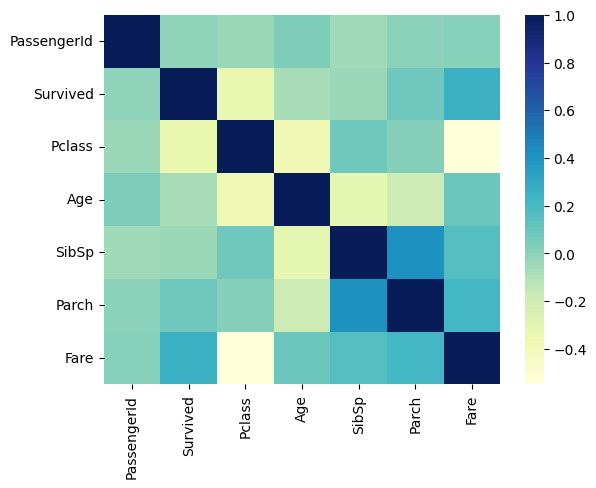

In [1]:
from titanic_fairy.helpers.load_and_save import Load
from titanic_fairy.helpers.train_test_split import stratified_split
from titanic_fairy.metrics.graphics import show_heatmap, check_train_test_split

titanic_raw_train = Load(train_path = "../dataset/train.csv")
show_heatmap(titanic_raw_train)

A primera vista, la clase y el precio del ticekt parecen influir en la supervivencia. No se ven efectos en la edad, pero esto puede deberse a un problema de escala de las variables. 

Con esto en mente reliazemos la separacion entre Train y Test. Consideramos la posibillidad de clases desbalanceadas, por lo tanto ocupamos una separacion estratificada en base a Sexo, Pclass y Supervivencia. 

En la siguiente grafica se observa que la separacion es efectivamente balanceada.


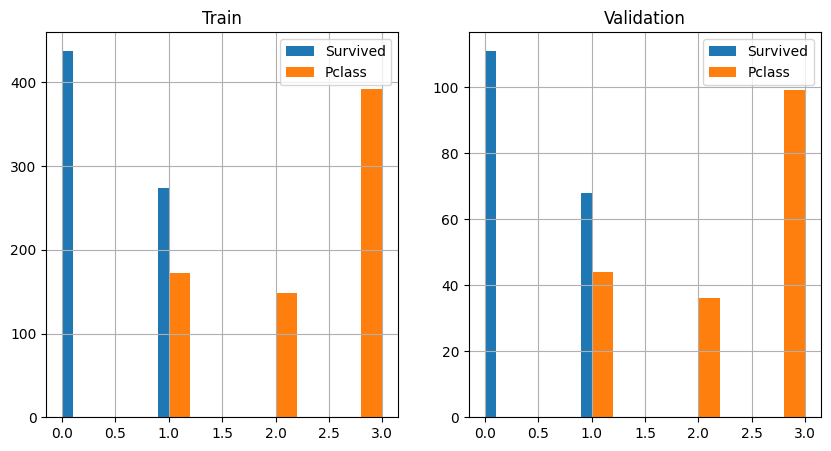

In [3]:
raw_train, raw_test = stratified_split(titanic_raw_train)

check_train_test_split(raw_train, raw_test)